# Distortion Classification

In [1]:
import torch
import torchaudio
import os

### Define transformation

In [2]:
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1024,
        "n_mels": 64,
        "center": False})

#### Functions for training

In [3]:
from src.gtfxdataset import GtFxDataset
from src.util import plot_spectrogram
from src.extrector import train
from src.extrector import model
from torch import nn

AUDIO_DIR = "_assets/DATASET/GT-FX-C53/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")
EFFECT_MAP = ["distortion", "chorus", "tremolo", "delay", "reverb"]

def load_data(effect):
    
    fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device,
                        effect=EFFECT_MAP[effect])
    return fxData

def split_data(data):

    BATCH_SIZE = round(len(data) / 1500)

    split_ratio = [0.8, 0.1, 0.1]
    train_set, test_set, val_set = torch.utils.data.random_split(data, lengths=split_ratio)

    train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
    test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
    val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)

    return train_dataloader, test_dataloader, val_dataloader   

#### Add Tensorboard to record data

In [4]:
from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_NAME = "c53_parameter"
EVU_DIR = "_log/Evaluation/"

if not os.path.exists('%s' % LOG_DIR):
    os.makedirs('%s' % LOG_DIR)

if not os.path.exists('%s' % EVU_DIR):
    os.makedirs('%s' % EVU_DIR)

log_writer = SummaryWriter(LOG_DIR)


#### Model training

Using device cpu
There are 209844 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])
input feature:


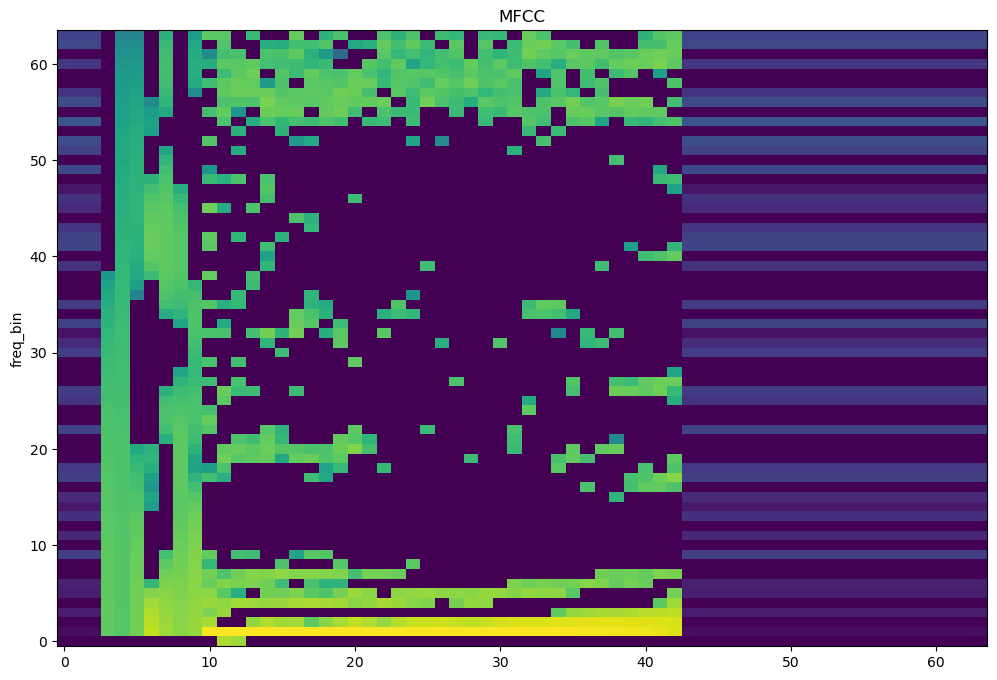

Epoch 1
loss: 0.058751  [  0/167876]
loss: 0.017773  [2800/167876]
loss: 0.009626  [5600/167876]
loss: 0.005877  [8400/167876]
loss: 0.003118  [11200/167876]
loss: 0.003669  [14000/167876]
loss: 0.004042  [16800/167876]
loss: 0.003146  [19600/167876]
loss: 0.003771  [22400/167876]
loss: 0.002436  [25200/167876]
loss: 0.004353  [28000/167876]
loss: 0.003582  [30800/167876]
loss: 0.003744  [33600/167876]
loss: 0.003211  [36400/167876]
loss: 0.003767  [39200/167876]
loss: 0.004367  [42000/167876]
loss: 0.002261  [44800/167876]
loss: 0.002265  [47600/167876]
loss: 0.001838  [50400/167876]
loss: 0.009375  [53200/167876]
loss: 0.003145  [56000/167876]
loss: 0.002096  [58800/167876]
loss: 0.002964  [61600/167876]
loss: 0.001953  [64400/167876]
loss: 0.002099  [67200/167876]
loss: 0.002126  [70000/167876]
loss: 0.001289  [72800/167876]
loss: 0.002909  [75600/167876]
loss: 0.001374  [78400/167876]
loss: 0.001871  [81200/167876]
loss: 0.001507  [84000/167876]
loss: 0.002105  [86800/167876]
loss:

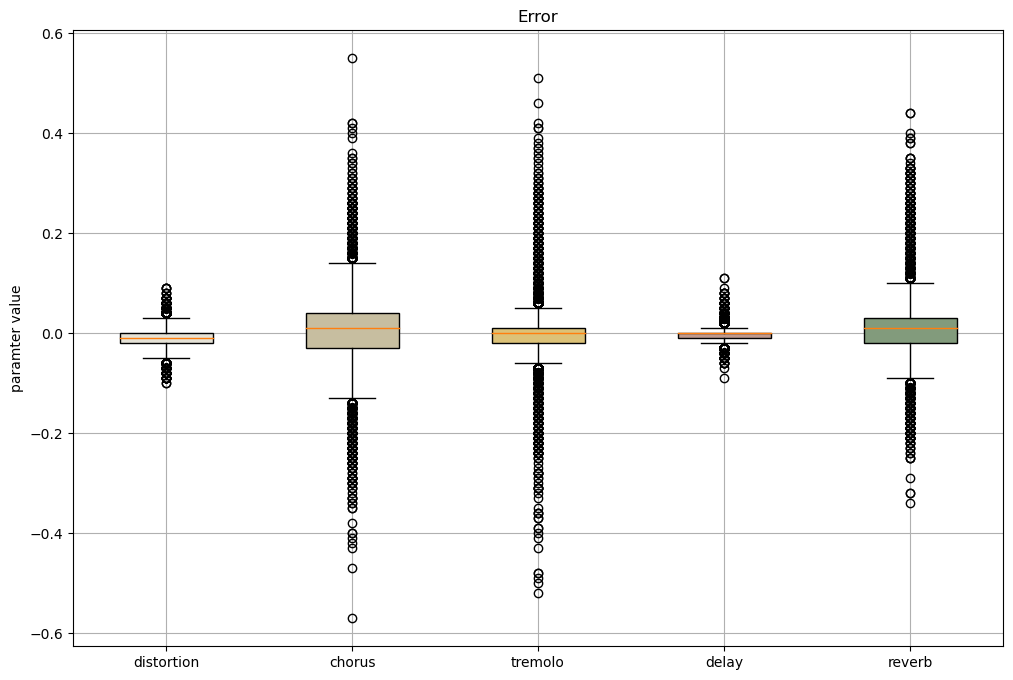

In [5]:
from src.util import plot_box
import numpy as np

WEIGHTS_DIR = "_weights/"
LEARNING_RATE = 0.001
EPOCHS = 20

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

error = [[], [], [], [], []]

for fx in range(5):

    WEIGHTS_PATH = os.path.join(WEIGHTS_DIR, EXPERIMENT_NAME + "_" + str(fx))

    if not os.path.exists('%s' % WEIGHTS_DIR):
        os.makedirs('%s' % WEIGHTS_DIR)

    fxData = load_data(fx)
    train_dataloader, test_dataloader, val_dataloader = split_data(fxData)
    
    # construct model and assign it to device
    cnn = model.Extractor().to(device)
    
    if fx == 0:
        signal, _, _, _, _ = fxData[0]
        print(f"There are {len(fxData)} samples in the dataset.")
        print(f"Shape of signal: {signal.shape}")

        print("input feature:")
        log_writer.add_figure("Input Feature", plot_spectrogram(signal[0], title="MFCC"))
        log_writer.add_graph(cnn, signal.unsqueeze_(0))

    # initialise loss funtion + optimiser
    loss_fn = nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

    # train model
    train.train(cnn,
                train_dataloader,
                test_dataloader,
                loss_fn,
                optimiser,
                device,
                log_writer,
                EPOCHS,
                WEIGHTS_PATH,
                effect=fx)

    _, _, log = train.test(cnn, val_dataloader, device, effect=fx)
    for _, data in enumerate(log):
        error[fx].append(data[3])

arr = np.array(error)
np.save(EVU_DIR + EXPERIMENT_NAME + "_evaluation.npy", arr)

log_writer.add_figure("Error Box", 
                      plot_box(error, title="Error", labels=EFFECT_MAP, ylabel="paramter value"))

log_writer.close()